In [2]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

O-ring failure? Temp (F)
[[  0.  66.]
 [  1.  70.]
 [  0.  69.]
 [  0.  68.]
 [  0.  67.]
 [  0.  72.]
 [  0.  73.]
 [  0.  70.]
 [  1.  57.]
 [  1.  63.]
 [  1.  70.]
 [  0.  78.]
 [  0.  67.]
 [  1.  53.]
 [  0.  67.]
 [  0.  75.]
 [  0.  70.]
 [  0.  81.]
 [  0.  76.]
 [  0.  79.]
 [  0.  75.]
 [  0.  76.]
 [  1.  58.]]


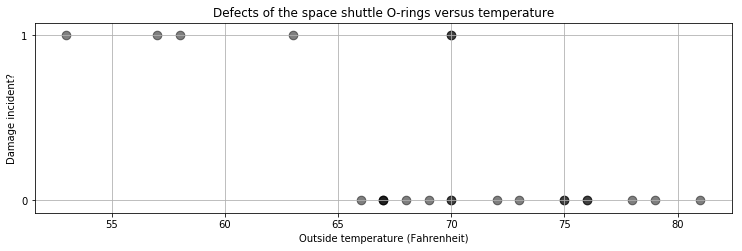

In [19]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("challenger_data.csv",
                                skip_header = 1,
                                 usecols=[1, 2],
                                missing_values="NA",
                                delimiter=",")
# Drop the NA values.
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]
challenger_data[:,0] = challenger_data[:,0]>0
# Plot it, as a function of temperature (the first column).
print "O-ring failure? Temp (F)"

print challenger_data

plt.scatter(challenger_data[:, 1], challenger_data[:, 0], s=75,
            color="k", alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.grid()
plt.title("Defects of the space shuttle O-rings versus temperature");

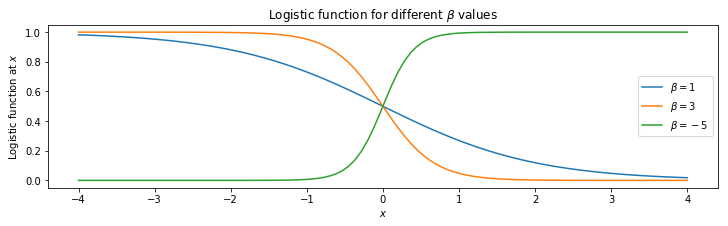

In [28]:
figsize(12, 3)

def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.xlabel(r"$x$")
plt.ylabel("Logistic function at $x$")
plt.title(r"Logistic function for different $\beta$ values")
plt.legend();

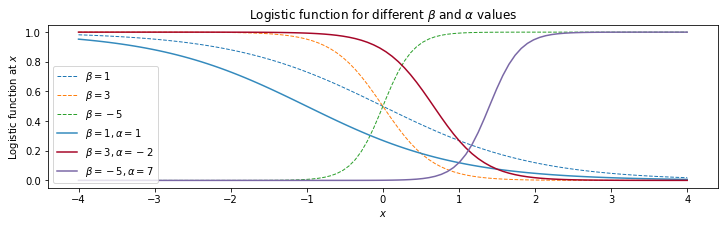

In [31]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))
x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.title(r"Logistic function for different $\beta$ and $\alpha$ values")
plt.xlabel("$x$")
plt.ylabel("Logistic function at $x$")
plt.legend(loc="lower left");

In [38]:
import pymc as pm

temperature = challenger_data[:, 1]
D = challenger_data[:, 0] # defect or not?

# Notice the "value" here. We will explain it later.
beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)


@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta*t + alpha))

In [39]:
# Connect the probabilities in "p" with our observations through a
# Bernoulli random variable.
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)

model = pm.Model([observed, beta, alpha])

# mysterious code to be explained in Chapter 3
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

/Users/egor/anaconda/envs/pymc_book/lib/python2.7/site-packages/scipy/optimize/optimize.py:1932: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)


 [-----------------100%-----------------] 120000 of 120000 complete in 9.1 sec

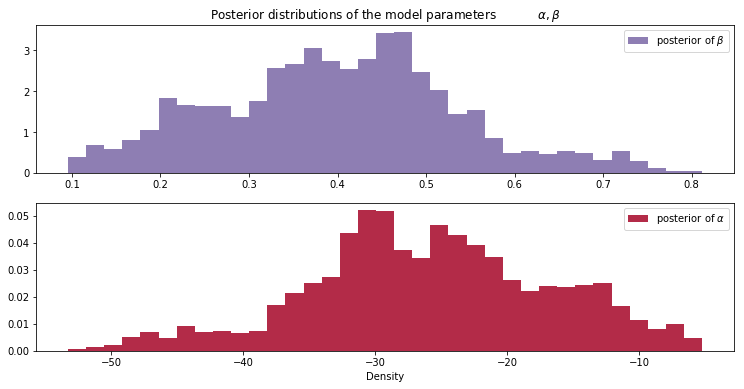

In [40]:
alpha_samples = mcmc.trace('alpha')[:, None] # best to make them 1D
beta_samples = mcmc.trace('beta')[:, None]

figsize(12.5, 6)

# histogram of the samples
plt.subplot(211)
plt.title(r"Posterior distributions of the model parameters \
          $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.xlabel("Value of parameter")
plt.xlabel("Density")
plt.legend();

In [41]:
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

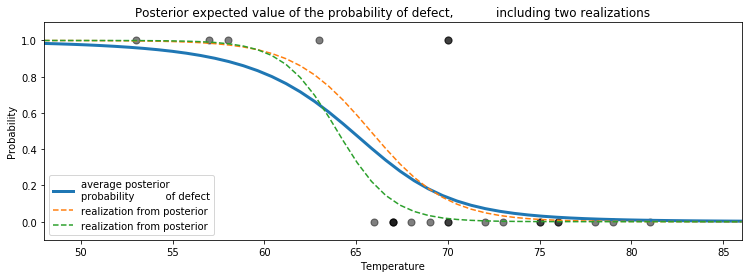

In [42]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
         of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of the probability of defect, \
          including two realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("Probability")
plt.xlabel("Temperature");

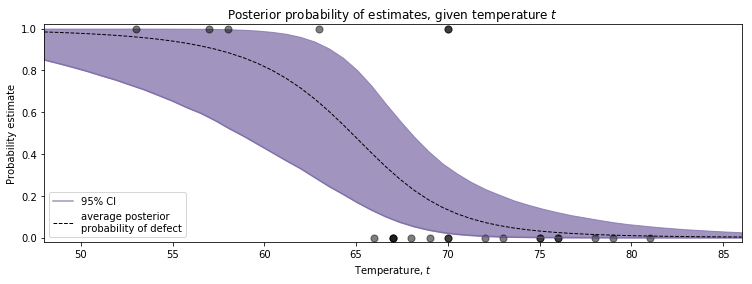

In [43]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "credible interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")
plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("Temperature, $t$")

plt.ylabel("Probability estimate")
plt.title("Posterior probability of estimates, given temperature $t$");

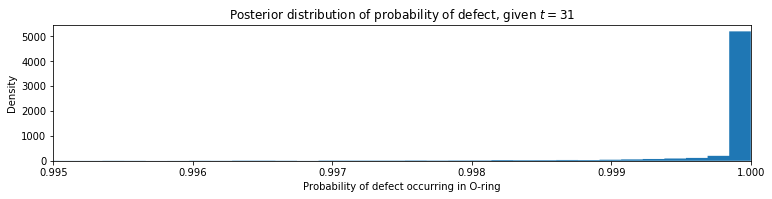

In [46]:
figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.ylabel("Density")
plt.xlabel("Probability of defect occurring in O-ring");



In [51]:
simulated_data = pm.Bernoulli("simulation_data", p)

simulated = pm.Bernoulli("bernoulli_sim", p)
N = 10000

mcmc = pm.MCMC([simulated, alpha, beta, observed])
mcmc.sample(N)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.9 sec

Shape of simulations array:  (10000, 23)


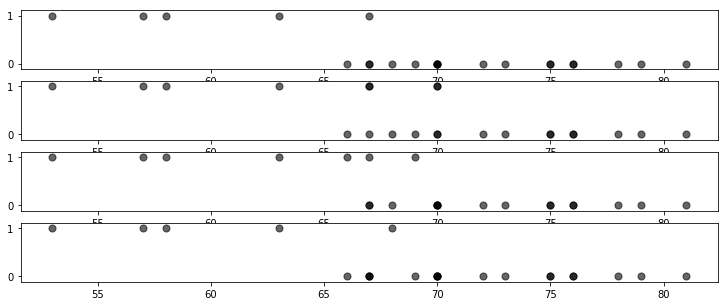

In [52]:
figsize(12.5, 5)

simulations = mcmc.trace("bernoulli_sim")[:].astype(int)
print "Shape of simulations array: ", simulations.shape

plt.title("Simulated datasets using posterior parameters")
figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temperature, simulations[1000*i, :], color="k",
                s=50, alpha=0.6);